In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.duplicated().sum()

116925

In [5]:
df.drop_duplicates().sum()

PJME_MW    994146776.0
dtype: float64

In [6]:
unique_values = df.nunique().sum()
print("Total number of unique values in the dataset:", unique_values)

Total number of unique values in the dataset: 28441


In [7]:
non_null_values = df.count().sum()
print("Total number of non-null values in the dataset:", non_null_values)

Total number of non-null values in the dataset: 145366


In [8]:
total_values = df.size
print("Total number of values in the dataset:", total_values)

Total number of values in the dataset: 145366


<function matplotlib.pyplot.show(close=None, block=None)>

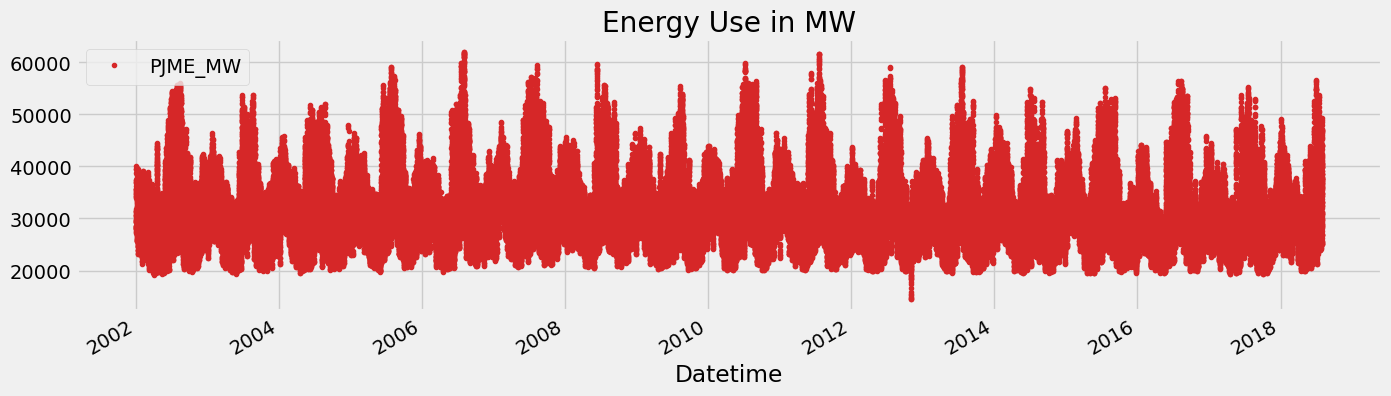

In [9]:
df.plot(style='.',
        figsize=(15, 4),
        color=color_pal[3],
        title='Energy Use in MW')
plt.show

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [11]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.0,62009.0


# Train - Test Split

In [13]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [14]:
train.tail(5)

,PJME_MW
Datetime,
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0
2014-01-01 23:00:00,32215.0
2014-01-02 00:00:00,30159.0


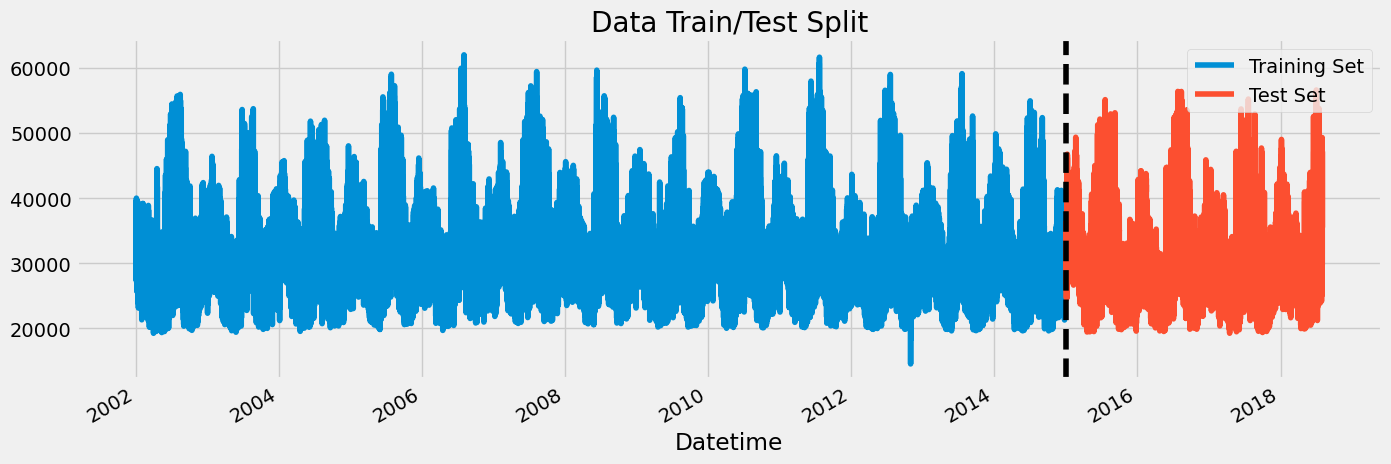

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

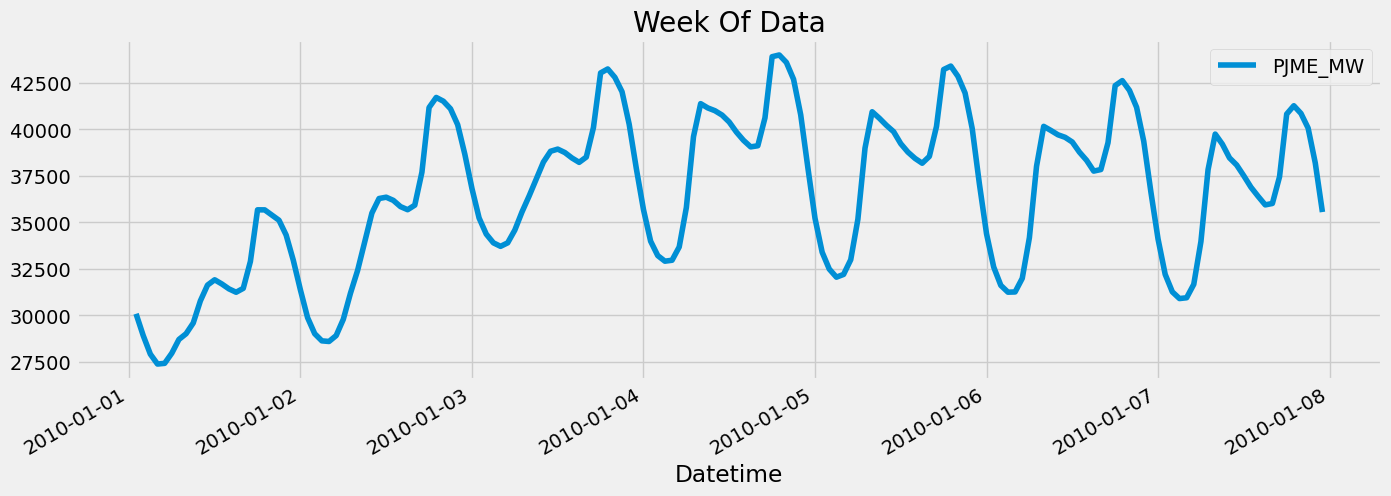

In [16]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [17]:
df = df.copy()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

In [18]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


# Visualize our Feature / Target Relationship

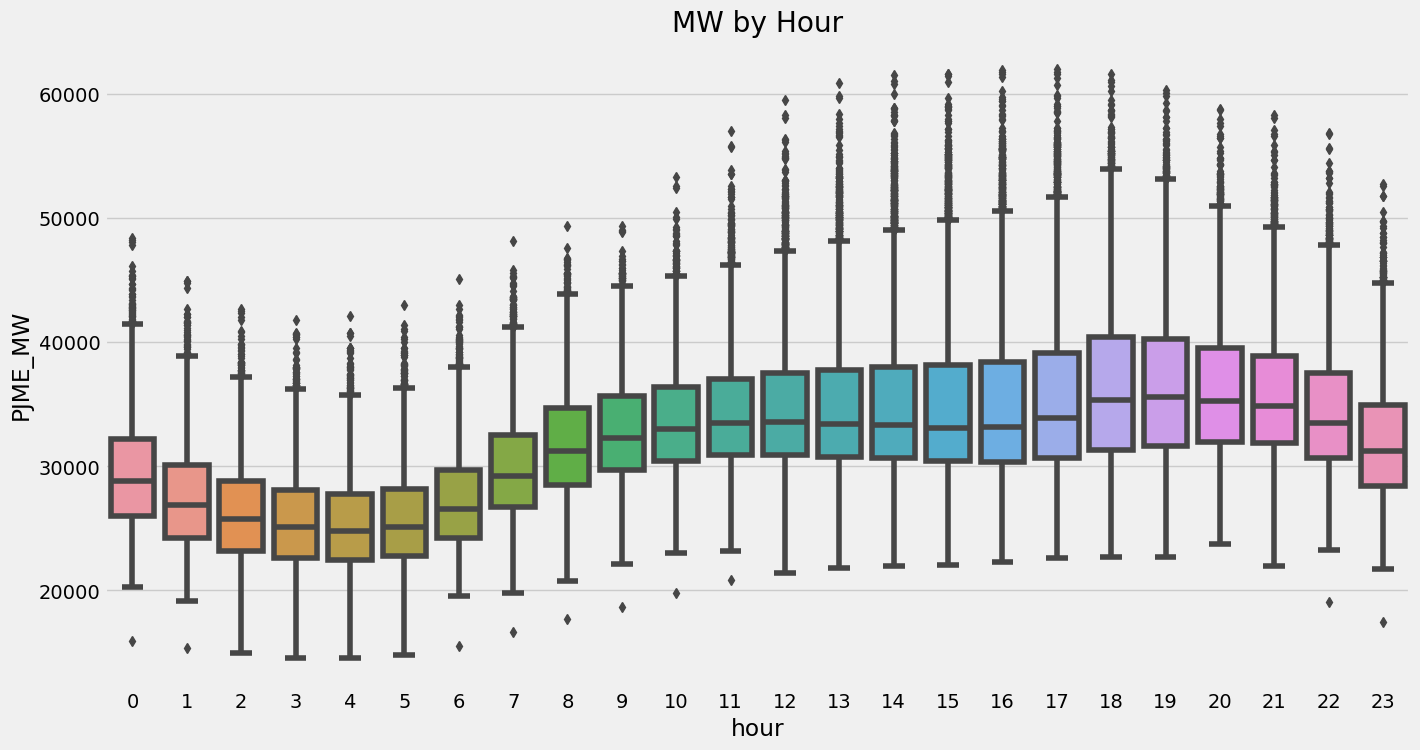

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

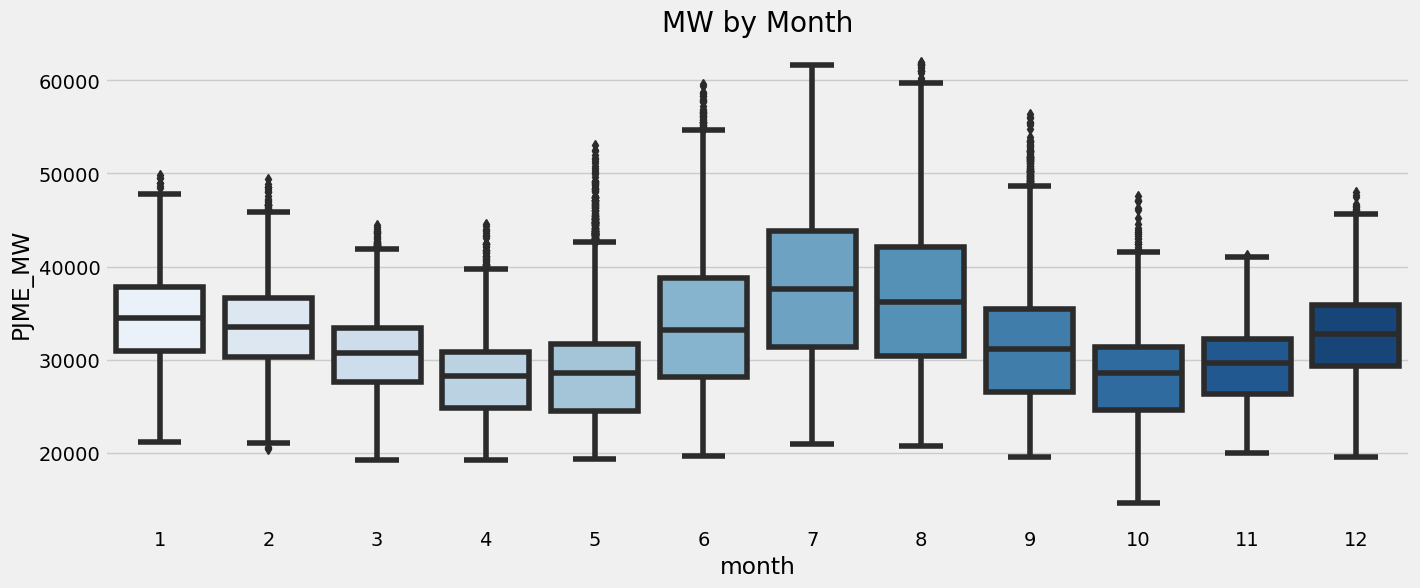

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

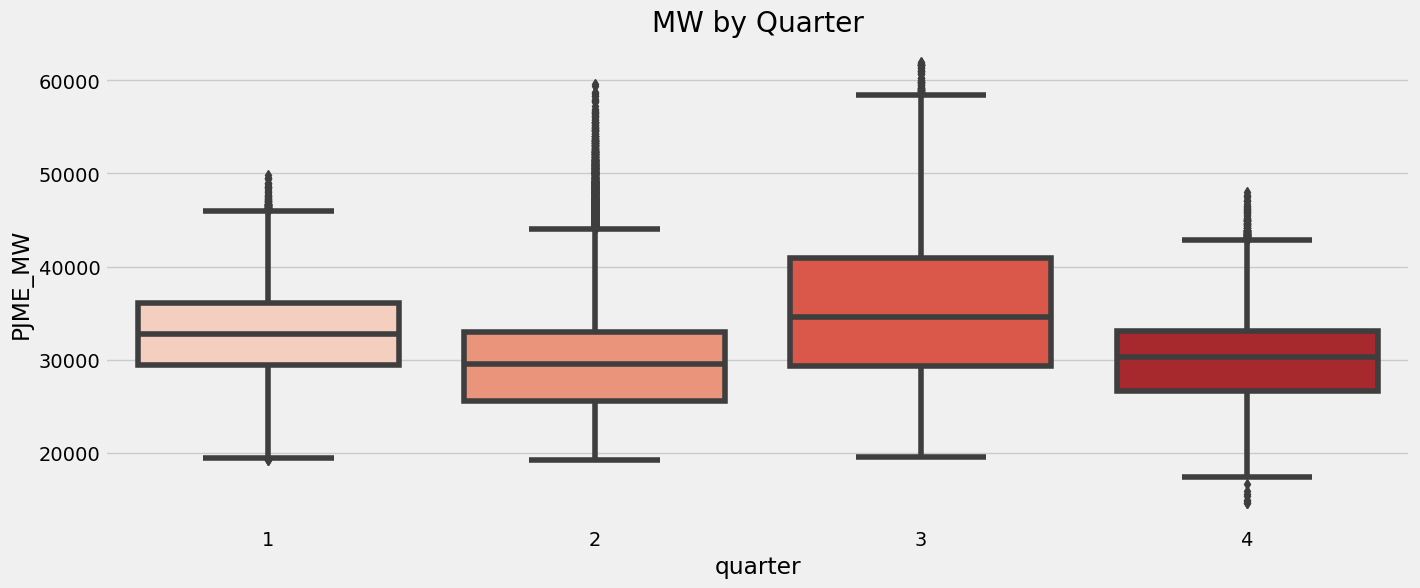

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x='quarter', y='PJME_MW', palette='Reds')
ax.set_title('MW by Quarter')
plt.show()

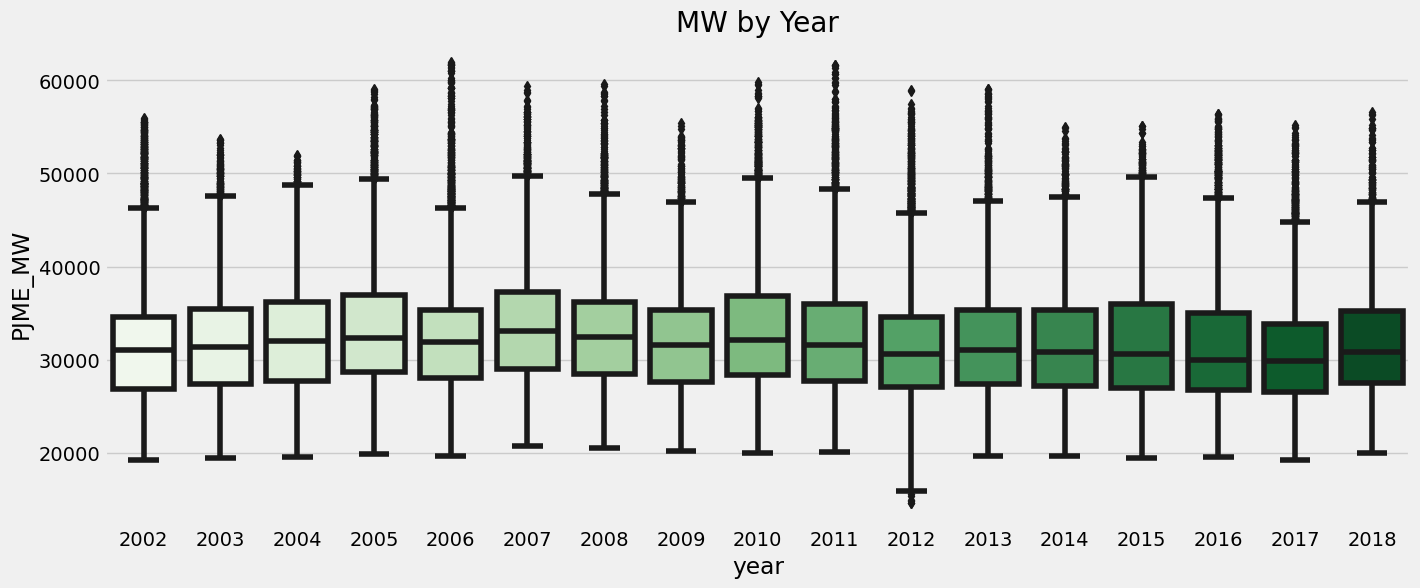

In [22]:
ig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x='year', y='PJME_MW', palette='Greens')
ax.set_title('MW by Year')
plt.show()

# ARIMA MODELS

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

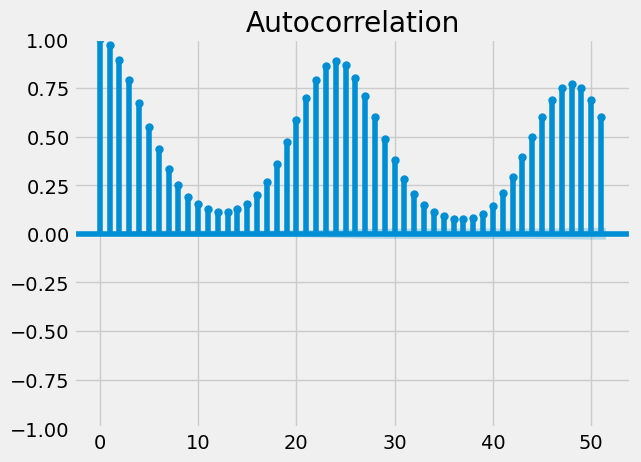

In [24]:
acf_original = plot_acf(train['PJME_MW'])

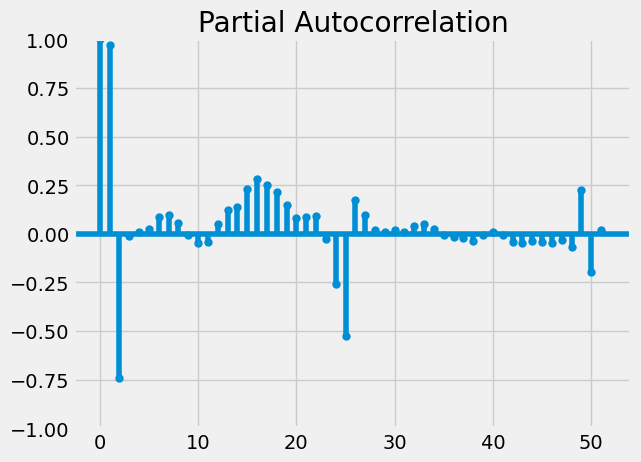

In [25]:
pacf_original = plot_pacf(train['PJME_MW'])

In [26]:
differenced_train = train['PJME_MW'].diff().dropna()

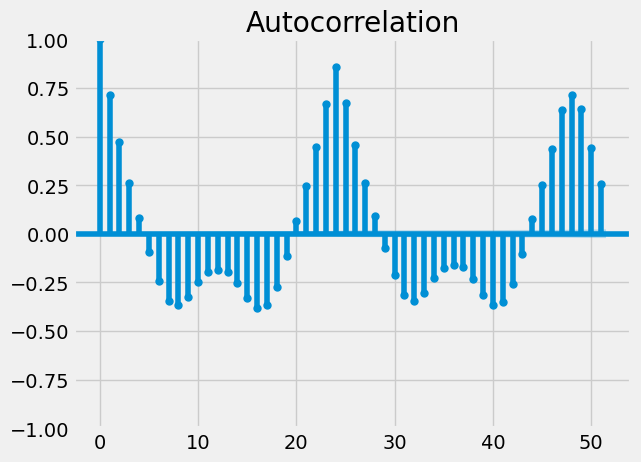

In [27]:
acf_original = plot_acf(differenced_train)

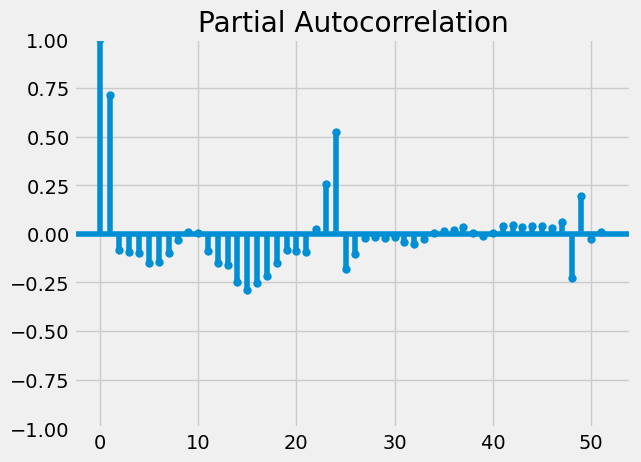

In [28]:
pacf_original = plot_pacf(differenced_train)

# Grid Search

In [29]:
%matplotlib inline
# Ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [30]:
from pmdarima import auto_arima
#stepwise_fit=auto_arima(train['PJME_MW'], start_p=0, start_q=0, max_p=14, max_q=14, seasonal=True, trace=True)

# arima 

In [31]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['PJME_MW'])

1. ADF :  -18.828912729084124
2. P-Value :  2.022124508152674e-30
3. Num Of Lags :  74
4. Num Of Observations Used For ADF Regression: 145291
5. Critical Values :
	 1% :  -3.430395009088914
	 5% :  -2.861559893380481
	 10% :  -2.5667805885384065


In [32]:
#from pmdarima import auto_arima
#stepwise_fit = auto_arima(df['PJME_MW'], trace=True,
#suppress_warnings=True)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [34]:
# Perform model selection to determine the optimal order (p, d, q) of the ARIMA model
model_arima = ARIMA(train['PJME_MW'], order=(8,1,4))  # Example order: ARIMA(8, 1, 4)

# Fit the ARIMA model to the training data
model_arima_fit = model_arima.fit()

In [35]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:               113926
Model:                 ARIMA(8, 1, 4)   Log Likelihood             -949593.609
Date:                Thu, 23 May 2024   AIC                        1899213.218
Time:                        16:09:44   BIC                        1899338.581
Sample:                             0   HQIC                       1899251.041
                             - 113926                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3593      0.004     88.435      0.000       0.351       0.367
ar.L2          0.0857      0.006     15.022      0.000       0.075       0.097
ar.L3          0.1472      0.006     25.821      0.0

In [36]:
test['PJME_MW'].index[0]

Timestamp('2015-01-01 00:00:00')

In [37]:
test['PJME_MW'].index[-1]

Timestamp('2018-01-02 00:00:00')

In [38]:
# Adjust the start and end values based on the available index
start_date = pd.to_datetime('2015-01-01 00:00:00')
end_date = pd.to_datetime('2018-01-02 00:00:00')

In [39]:
# Calculate the integer offsets for start and end dates
start_offset = test['PJME_MW'].index.get_loc(start_date)
end_offset = test['PJME_MW'].index.get_loc(end_date)

In [40]:
# Generate predictions for the testing set using the updated offsets
predictions_arima = model_arima_fit.predict(start=start_offset, end=end_offset)

In [41]:
predictions_arima.head() # There is a problem with starting time

Datetime
2002-12-31 01:00:00        0.000000
2002-12-31 02:00:00    39889.816682
2002-12-31 03:00:00    22753.974444
2002-12-31 04:00:00    22977.724852
2002-12-31 05:00:00    23303.123233
Name: predicted_mean, dtype: float64

In [42]:
predictions_arima.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2005-06-01 22:00:00', '2005-06-01 23:00:00',
               '2005-06-02 00:00:00', '2005-05-31 01:00:00',
               '2005-05-31 02:00:00', '2005-05-31 03:00:00',
               '2005-05-31 04:00:00', '2005-05-31 05:00:00',
               '2005-05-31 06:00:00', '2005-05-31 07:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=31440, freq=None)

In [43]:
# Update the start date of the predictions_arima time series
start_date = pd.to_datetime('2015-01-01 00:00:00')
predictions_arima.index = pd.date_range(start=start_date, periods=len(predictions_arima), freq='H')

# Verify the updated start date
print(predictions_arima.index[0])

2015-01-01 00:00:00


In [44]:
predictions_arima.tail()

2018-08-02 19:00:00    21233.044684
2018-08-02 20:00:00    21128.968779
2018-08-02 21:00:00    21090.221719
2018-08-02 22:00:00    22280.974760
2018-08-02 23:00:00    24858.971314
Freq: H, Name: predicted_mean, dtype: float64

In [45]:
from sklearn.metrics import mean_squared_error
# Calculate the mean squared error (MSE)
mse_arima = mean_squared_error(test['PJME_MW'], predictions_arima)
print("Mean Squared Error (MSE):", mse_arima)


Mean Squared Error (MSE): 66030941.455282554


In [46]:
# Calculate the root mean squared error (RMSE)
rmse_arima = np.sqrt(mse_arima)
print("Root Mean Squared Error (RMSE):", rmse_arima)


Root Mean Squared Error (RMSE): 8125.942496429725


In [47]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_arima = np.mean(np.abs((test['PJME_MW'] - predictions_arima) / test['PJME_MW'])) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_arima)


Mean Absolute Percentage Error (MAPE): 22.9250521113973


In [48]:
test['predictions_arima'] = predictions_arima
df = df.merge(test[['predictions_arima']], how='left', left_index=True, right_index=True)

In [49]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions_arima
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,21128.968779
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,21090.221719
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,22280.974760
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,24858.971314
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,NaN


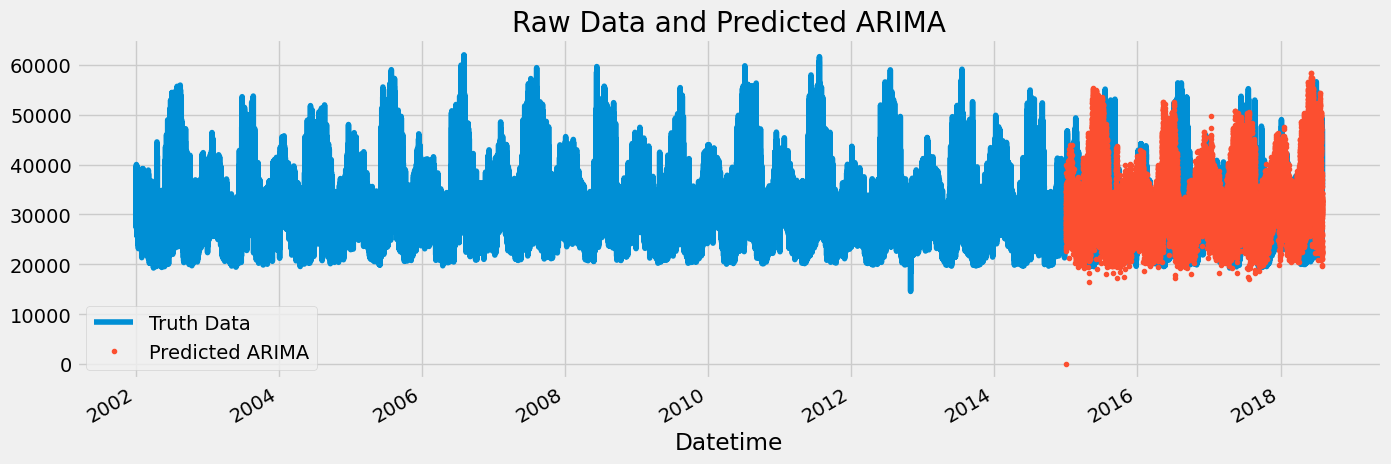

In [50]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['predictions_arima'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predicted ARIMA'])
ax.set_title('Raw Data and Predicted ARIMA')
plt.show()

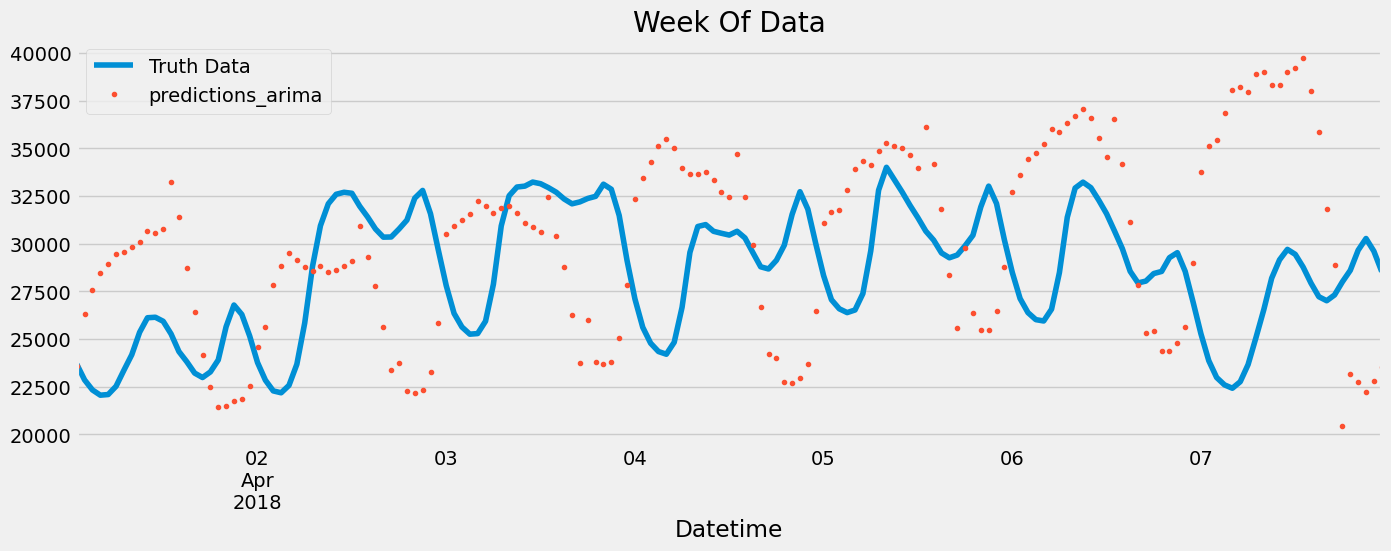

In [51]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions_arima'] \
    .plot(style='.')
plt.legend(['Truth Data','predictions_arima'])
plt.show()

# LightGBM Model


In [52]:
from sklearn.model_selection import train_test_split,ShuffleSplit, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [53]:
#pip install lightgbm

In [54]:
from lightgbm import LGBMRegressor

In [55]:
lgbm = LGBMRegressor()
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions_arima
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN


In [56]:
train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [57]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [58]:
train.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions_arima
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN


In [59]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [60]:
lgbm_model = lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Info] Start training from score 32289.296912


In [61]:
y_pred = lgbm_model.predict(X_test, 
                   num_iteration = lgbm_model.best_iteration_)

In [62]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming y_pred is the array of predicted values

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error (MSE): 15307882.38445577
Root Mean Squared Error (RMSE): 3912.5288988652555
Mean Absolute Percentage Error (MAPE): 9.278372867836762


#  Light GBM Model- Model Tuning

In [63]:
#lgbm_grid = {'learning_rate': [0.01,0.1,0.5,1], 'n_estimators': [20,40,100,200,500,1000],'max_depth': [2,3,4,5,6,7,8]}

In [64]:
lgbm = LGBMRegressor()

In [65]:
#lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv= 10, n_jobs= -1, verbose = 2)

In [66]:
#lgbm_cv_model.best_params_

In [70]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.1, 
                           max_depth = 3, 
                           n_estimators = 100)

In [71]:
lgbm_tuned = lgbm_tuned.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 113926, number of used features: 6
[LightGBM] [Info] Start training from score 32289.296912


In [72]:
y_pred_ligtgbm_tuned = lgbm_tuned.predict(X_test)

# Score ligtgbm after tunning

In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score

# Assuming y_test contains the actual values and y_pred_ligtgbm_tuned contains the predicted values

# Calculate the MSE
mse_ligtgbm_tuned = mean_squared_error(y_test, y_pred_ligtgbm_tuned)
print("Mean Squared Error (MSE):", mse_ligtgbm_tuned)

# Calculate the RMSE
rmse_ligtgbm_tuned = np.sqrt(mean_squared_error(y_test, y_pred_ligtgbm_tuned))
print("Root Mean Squared Error (RMSE):", rmse_ligtgbm_tuned)

# Calculate the MAPE
mape_ligtgbm_tuned = np.mean(np.abs((y_test - y_pred_ligtgbm_tuned) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_ligtgbm_tuned)


Mean Squared Error (MSE): 13841773.429002896
Root Mean Squared Error (RMSE): 3720.453390247336
Mean Absolute Percentage Error (MAPE): 9.083640790440557


# Forecast on LightGBM

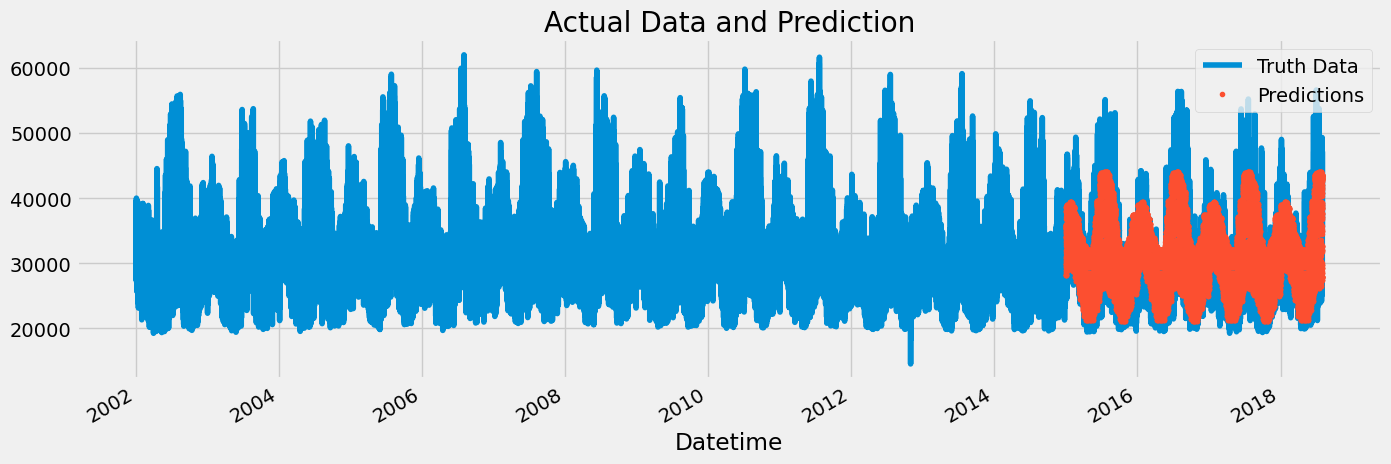

In [74]:
test['prediction_ligthgbm'] = y_pred_ligtgbm_tuned
df = df.merge(test[['prediction_ligthgbm']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_ligthgbm'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Actual Data and Prediction')
plt.show()

In [75]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions_arima,prediction_ligthgbm
Datetime,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,21128.968779,43495.010243
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,21090.221719,43172.156654
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,22280.974760,41412.927793
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,24858.971314,38518.874988
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,NaN,32622.765337


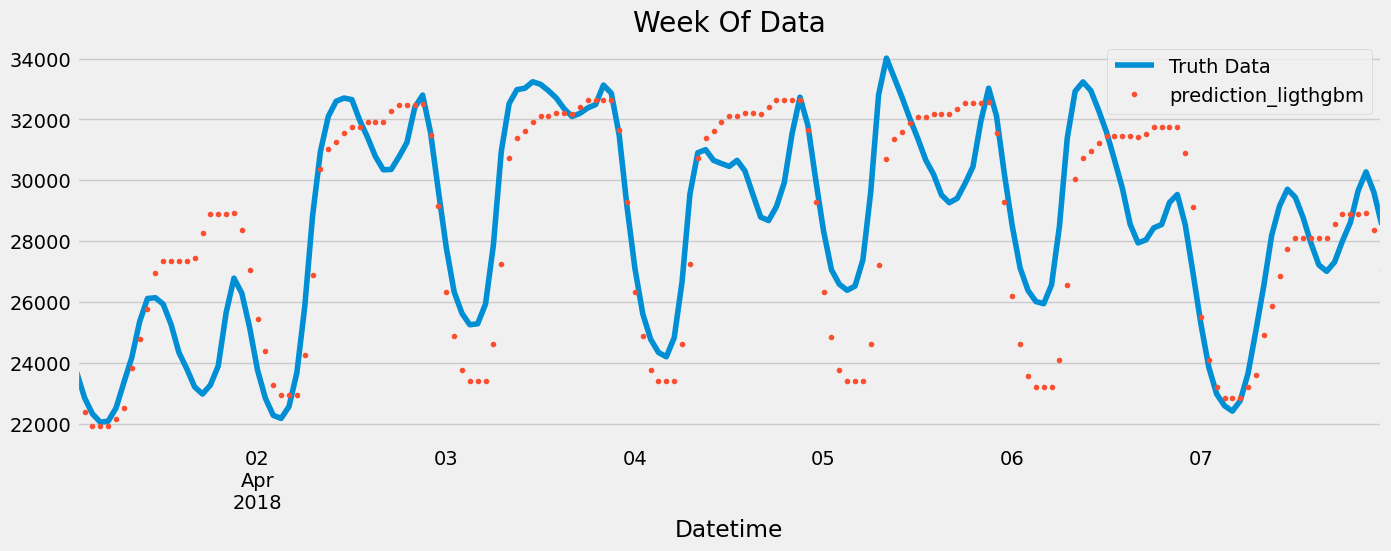

In [76]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08'), 'PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08'), 'prediction_ligthgbm'] \
    .plot(style='.')
plt.legend(['Truth Data', 'prediction_ligthgbm'])
plt.show()


# XGBRegressor

In [77]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31655.45562
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11746.32415
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.08785
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.20935
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.35923
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.11789
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3778.75818
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.15835
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.07616
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3729.70685
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.63043


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

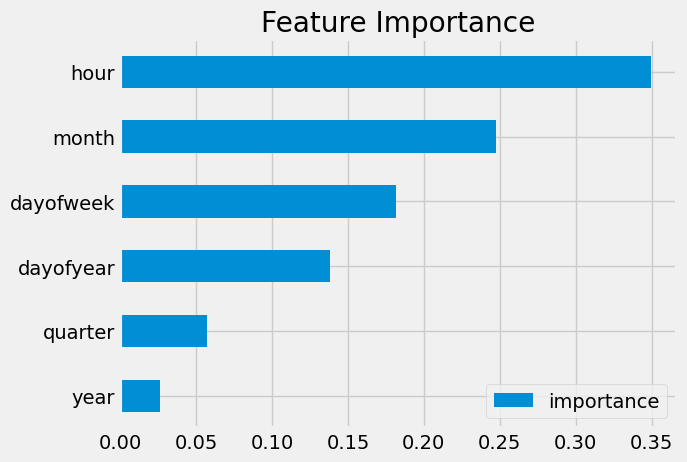

In [78]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

In [79]:
reg.predict(X_test)

array([30422.88 , 29308.064, 28400.99 , ..., 40804.1  , 37933.54 ,
       31588.26 ], dtype=float32)

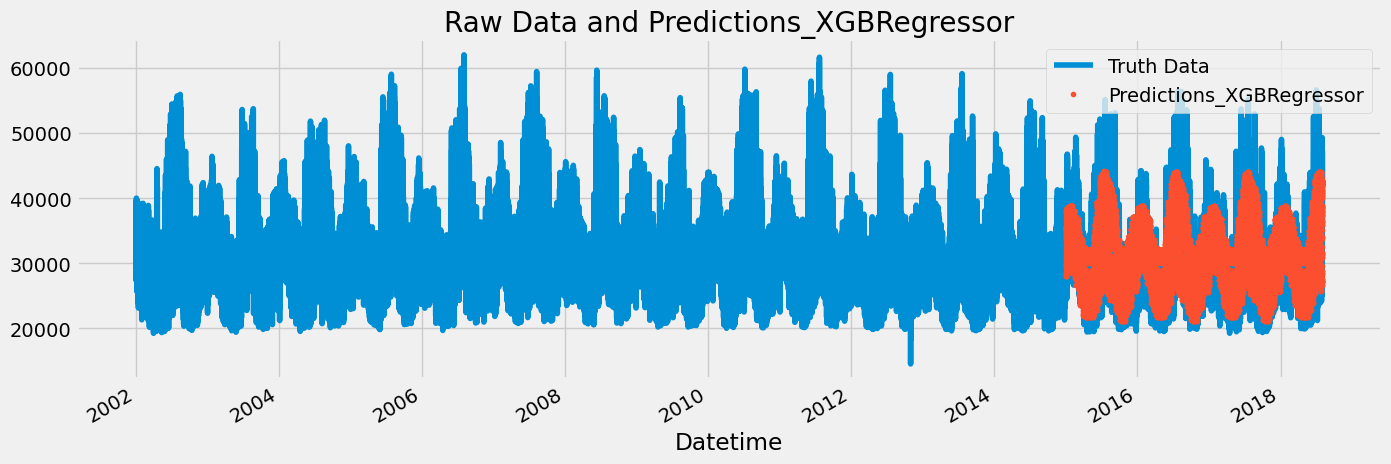

In [80]:
import matplotlib.pyplot as plt

# Assuming 'reg' is your trained XGBRegressor model, 'X_test' is the test data, and 'df' is your DataFrame
test['Predictions_XGBRegressor'] = reg.predict(X_test)
df = df.merge(test[['Predictions_XGBRegressor']], how='left', left_index=True, right_index=True)

# Plotting
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['Predictions_XGBRegressor'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions_XGBRegressor'])
ax.set_title('Raw Data and Predictions_XGBRegressor')
plt.show()


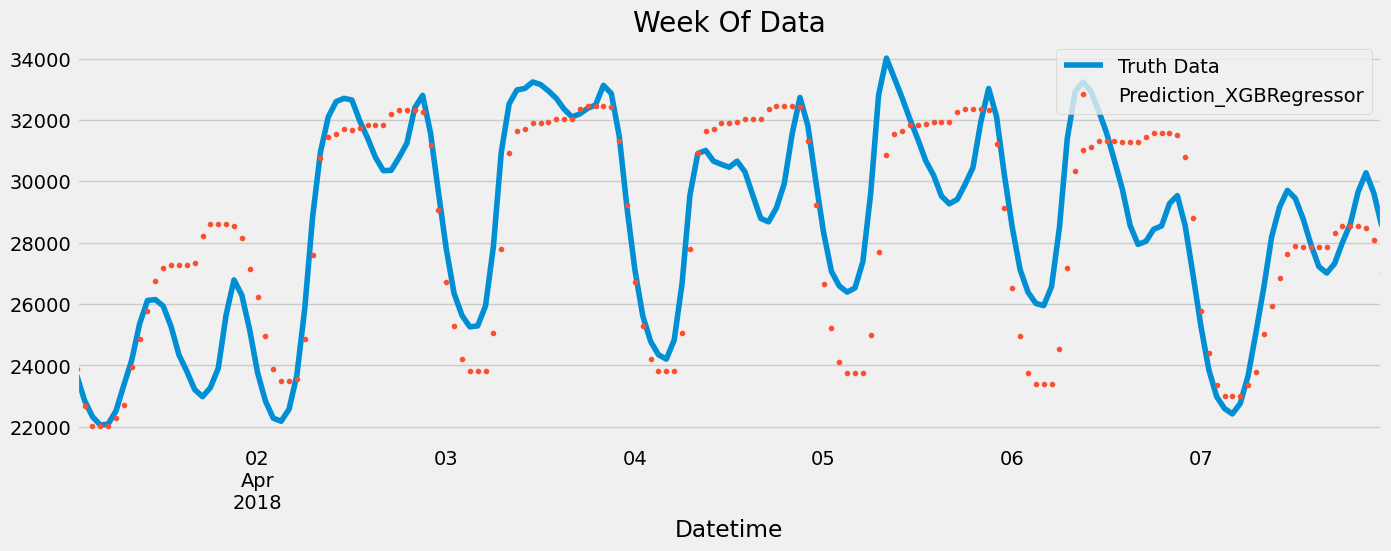

In [81]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['Predictions_XGBRegressor'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction_XGBRegressor'])
plt.show()

In [82]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score

# Assuming test['PJME_MW'] contains the actual values and test['Predictions_XGBRegressor'] contains the predicted values

# Calculate the RMSE using the given syntax
rmse_XGBRegressor = np.sqrt(mean_squared_error(test['PJME_MW'], test['Predictions_XGBRegressor']))
print(f'RMSE Score on Test set: {rmse_XGBRegressor:0.2f}')

# Calculate the MAPE
mape_XGBRegressor = np.mean(np.abs((test['PJME_MW'] - test['Predictions_XGBRegressor']) / test['PJME_MW'])) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_XGBRegressor)

# Calculate the MSE
mse_XGBRegressor = mean_squared_error(test['PJME_MW'], test['Predictions_XGBRegressor'])
print("Mean Squared Error (MSE):", mse_XGBRegressor)



RMSE Score on Test set: 3726.49
Mean Absolute Percentage Error (MAPE): 9.161466030733635
Mean Squared Error (MSE): 13886692.696853897


## CALCULATE ERROR
### The Worst estimated dates

In [83]:
test['error'] = np.abs(test[TARGET] - test['Predictions_XGBRegressor'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

### The Best estimated dates

In [84]:
test['error'] = np.abs(test[TARGET] - test['Predictions_XGBRegressor'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    322.958008
2015-10-28    426.451335
2016-10-27    543.167155
2015-05-06    556.749674
2017-10-15    569.468262
2018-05-16    569.951009
2015-11-06    678.310140
2017-04-07    687.475911
2016-12-29    706.143392
2016-09-16    711.019694
Name: error, dtype: float64

In [85]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions_arima,prediction_ligthgbm,Predictions_XGBRegressor
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,21128.968779,43495.010243,42575.265625
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,21090.221719,43172.156654,42522.703125
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,22280.974760,41412.927793,40804.101562
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,24858.971314,38518.874988,37933.539062
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,NaN,32622.765337,31588.259766


In [86]:
df.isnull().sum()

PJME_MW                          0
hour                             0
dayofweek                        0
quarter                          0
month                            0
year                             0
dayofyear                        0
dayofmonth                       0
weekofyear                       0
predictions_arima           113927
prediction_ligthgbm         113926
Predictions_XGBRegressor    113926
dtype: int64